In this notebook I will be looking at the rest of the tweets after the first 100k to get an understanding of the different topics people were talking about, and to try to understand how things have changed since the first 100k tweets.

In [11]:
import pandas as pd
#import gensim
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('max_colwidth',1000)
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import stopwords


In [4]:
final_data = pd.read_pickle("datanobots.pkl")
final_data = final_data[100000:]
final_data = final_data.reset_index()

In [5]:
urls = []
for x in final_data.entities:
    if x["urls"]:
        urls.append(x["urls"][0]["expanded_url"])

In [6]:
Counter(urls).most_common(20)

[('http://www.teenvogue.com/story/kathy-griffin-performative-outrage-relativity-shame-thigh-high-politics',
  5973),
 ('http://www.vulture.com/2016/12/kathy-griffin-comedy-should-go-hard-on-trump.html',
  5547),
 ('http://www.dailywire.com/news/16998/disgusting-kathy-griffin-holds-trumps-bloody-hank-berrien',
  5071),
 ('https://twitter.com/kathygriffin/status/5249479639', 4459),
 ('http://www.theamericanmirror.com/satan-worshipers-disavow-kathy-griffin-grotesque-trump-behead/',
  3773),
 ('http://fxn.ws/2sdskCg', 3038),
 ('http://fxn.ws/2rl1Ezx', 2473),
 ('https://twitter.com/stockmonsterusa/status/869670612934901760', 2337),
 ('http://dailycaller.com/2017/05/30/should-cnn-snatch-kathy-griffin-off-its-new-years-eve-special/',
  2046),
 ('http://conservativefighters.com/kathy-griffin-petition/', 1862),
 ('https://twitter.com/realdonaldtrump/status/193051919260979201', 1516),
 ('http://theduffel.co/2qF9F56', 1452),
 ('http://ow.ly/LPgx30caKRp', 1419),
 ('https://www.google.com/amp/amp.t

Interesting, the most popular links are from Vulture and Teen Vogue--suggesting we have a pushback with liberal viewpoints compared to the first 100000 tweets.

Let's look at trying to do some topic modelling on these tweets. Like with the first 100000 tweets, I tried a 
variety of combinations of topics with LDA, NMF, count vectorizer and TFIDF vectorizer.
Here I will only be using NMF with 6 topics and TFIDF (it takes a while to run topic modelling with this many tweets)--which is what I used for my presentation as it led to the best topic clustering.

In [12]:
def get_wordnet_pos(row):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""
    treebank_tag = pos_tag([row])
    if treebank_tag[0][1].startswith('J'):
        return wordnet.ADJ
        print(treebank_tag)
    elif treebank_tag[0][1].startswith('V'):
        return wordnet.VERB

    elif treebank_tag[0][1].startswith('N'):
        return wordnet.NOUN

    elif treebank_tag[0][1].startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
#Again like with the first 100000 tweets...I did not want tweets to cluster around
#names like Kathy Griffin..so I removed them
stopwords = stopwords.words("english")  + ["Kathy", "Griffin", "Donald", "Trump", "kathy", "griffin", "rt", "...", "trump", "donald"]

In [14]:
def text_cleaner_and_stemmer(row):
    if type(row) != str :
        row = row.decode('utf-8')
    row = re.sub('@([A-Za-z0-9_]+)',' ', row)
    row = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ', row)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    row = regex.sub('', row)
    row = row.replace("RT", " ")
    row = word_tokenize(row)
    lemmatizer = WordNetLemmatizer()
    lemmatizer_fun = lambda x: lemmatizer.lemmatize(x, get_wordnet_pos(x))
    
    lemmatizer_fun_outer = lambda x: list(map(lemmatizer_fun, x))
    
    return generalize_fun(row, lemmatizer_fun_outer)
    

def generalize_fun(corpus, lambda_fun):
# must handle a list of lists (tokenized docs) and also a simple list
    try:
        if isinstance(corpus[0], list):
            # list of lists
            corpus = map(lambda_fun, corpus)
        else:
            # single list
            corpus = lambda_fun(corpus)
        return list(corpus)
    except:
        return ""

In [38]:

TV = TfidfVectorizer(ngram_range=(1, 1), 
                    stop_words=stopwords, 
   tokenizer = text_cleaner_and_stemmer,
token_pattern="\\b[a-z][a-z]+\\b", min_df=40, max_df=.95,
                    lowercase=True)

In [ ]:
X = TV.fit_transform(final_data.text)

In [21]:
def print_topic_top_words(model, cv, n_top_words=10):
    feature_names = cv.get_feature_names()
    
    for topic_vec in enumerate(model.components_):
        topic_num = topic_vec[0]
        topic_words = topic_vec[1]
        
        print('Topic {}:'.format(topic_num + 1))
        
        topic_values = sorted(zip(topic_words, feature_names), 
                              reverse=True)[:n_top_words]
    
        print(' '.join([y for x,y in topic_values]))
        # pprint(topic_values)
        
    return

In [19]:
nmf1 = NMF(n_components = 6, max_iter=50, random_state=42)
nmf1.fit(X)

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=50,
  n_components=6, nls_max_iter=2000, random_state=42, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [18]:
nmf = NMF(n_components = 7, max_iter=50, random_state=42)
nmf.fit(X)

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=50,
  n_components=7, nls_max_iter=2000, random_state=42, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [22]:
print_topic_top_words(nmf1, TV, n_top_words=20)

Topic 1:
child time hard photo shoot plot ample misspeak misstep reflectioncorrection photoshoot pose bloody offensive htt… bully beheading apologizes head condemn
Topic 2:
ashamed especially time… son 11 old barron year hard child white yr having… mirr… note men wasnt thought look ruin
Topic 3:
mannequin hang free apparently speech gop right doesnt obama get call ted nugent house amp line say want invite remember
Topic 4:
feel sensitive soul well awful hope photo disgust dont sympa… sort bit yall little offend stunt even make wore shoot
Topic 5:
cnn fire new eve year amp … president photo ’ host head program white say show shed appear agreement terminate
Topic 6:
away denier peop… comedic judgment error person climate great take try make disgust misdirects sethrich everyone part clearly record in…


In [23]:
print_topic_top_words(nmf, TV, n_top_words=20)

Topic 1:
child time hard photo shoot plot ample misspeak misstep reflectioncorrection photoshoot pose offensive beheading bloody htt… fire bully apologizes author
Topic 2:
ashamed especially time… son 11 old barron year hard child yr having… white thought mirr… note men warm harmful global
Topic 3:
mannequin hang free apparently speech doesnt right gop call obama get ted harmful nugent warm global remember leftist line hillary
Topic 4:
feel sensitive soul well awful hope photo disgust sympa… sort bit yall little offend stunt dont even make wore isi
Topic 5:
cnn new fire eve year program host agreement terminate appear show shed advertiser terminates … duty lose issue hey special
Topic 6:
away denier peop… comedic judgment error person climate great take try make disgust misdirects sethrich everyone yall sympa… part clearly
Topic 7:
’ white president amp say head photo ted career nugent retweet thing … woman hold think ruin shoot decapitate threaten


We see many more topics that seem to have liberal viewpoints in them: talks of client denial, ted nudget, obama mannequins, etc. We also see topics around Trump tweeting that the photo disturbed his children, and people responding (mocking) that.

I also want to look at is who is retweeting who.
This may give us some information about which side people are taking (as most tweets are retweets).


In [24]:
def aretweet(row):
    if row.split(" ")[0] == "RT":
        return True
    else:
        return False

In [27]:
final_data["was_retweeted"] = final_data.text.apply(lambda x: aretweet(x))

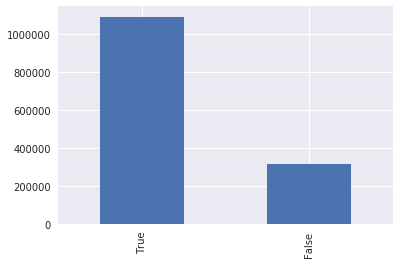

In [32]:
final_data.was_retweeted.value_counts().plot(kind="bar")

A great majority of Tweets were retweets.

In [36]:
final_data[~final_data.text.str.contains("RT")].sort_values("retweet_count", ascending=False)[["screen_name", "text"]].head(15)

,screen_name,text
372635,MelissaStetten,Trump: My children are having a hard time with Kathy Griffin's photo. \n\nHis children: https://t.co/o4zW7N0aqm
263342,realDonaldTrump,"Kathy Griffin should be ashamed of herself. My children, especially my 11 year old son, Barron, are having a hard time with this. Sick!"
1029797,JuddApatow,Kathy Griffin is a great person who made an error in comedic judgment. She is not a climate denier trying to take a… https://t.co/HyjQdfmNZr
883460,rickygervais,I hope these sensitive souls are feeling better about that awful Kathy Griffin photo. https://t.co/CmVtUzWtv5
1056261,GovMikeHuckabee,"Note to Kathy Griffin: it wasn't ""old white men"" that ruined your career. It was ONE OLD WHITE WOMAN. Look in the mirror to see who she is."
976627,DonaldJTrumpJr,To put everything into perspective this is a must read from Dec 16 even states it's ok to go after Barron an 11 y/o https://t.co/nNH5lLi3Hb
1064240,billoreilly,"Hope everyone saw Kathy Griffin &amp; her radical left attorney accuse @POTUS of ""bullying"" her. Could never happen in a sane society, but..."
59544,JackPosobiec,Hannity lost sponsors over discussing an unsolved murder. Kathy Griffin is a CNN host and they haven't even issued a statement
145969,KellyannePolls,Kathy Griffin did not misspeak or misstep. She plotted &amp; posed for photoshoot. Ample time for reflection/correction https://t.co/KmVygz2kfK
940336,PrisonPlanet,"Kathy Griffin: ""This is a woman thing.""\n\nNo, it's a 'don't do photo shoots with a decapitated president's head' thing, you complete idiot."


Interesting...we see a good amount of liberals being retweeted at the top (compared to first 100k tweets), but overall it appears that the most retweeted Tweets came from conservatives.